In [2]:
from torchgeo.datasets import Potsdam2D
import torch
import torchvision

In [4]:
import yaml
config_path = '/home/tu/tu_tu/tu_zxmav84/DS_Project/modules/config.yml'
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
path = config['data']['potsdam']

### Read in Data From Disk
- Data must be manually downloaded from here: https://seafile.projekt.uni-hannover.de/f/429be50cc79d423ab6c4/
- Use password: CjwcipT4-P8g

In [6]:
# Download the dataset if not already downloaded
potsdam_train = Potsdam2D(
    root=path, 
    split='train', 
    transforms=None, 
    checksum=False)

potsdam_test = Potsdam2D(
    root=path, 
    split='test', 
    transforms=None, 
    checksum=False)

print(f"""
      Train data: {len(potsdam_train)}
      Test data: {len(potsdam_test)}
      """)


      Train data: 24
      Test data: 14
      


### Assign RGB mask for labels and create converison dicts

##### Documentation from https://www.isprs.org/education/benchmarks/UrbanSemLab/semantic-labeling.aspx
Six categories/classes have been defined:

Impervious surfaces (RGB: 255, 255, 255)

Building (RGB: 0, 0, 255)

Low vegetation (RGB: 0, 255, 255)

Tree (RGB: 0, 255, 0)

Car (RGB: 255, 255, 0)

Clutter/background (RGB: 255, 0, 0)

In [7]:
RGB_classes = [
       (255, 255, 225), # impervious surfaces
       (0,  0, 255), # building
       (0, 255, 255), # low vegetation
       (0,  255,  0), # tree
       (255, 255, 0), # car
       (255, 0, 0)] # clutter/background
Label_classes = [
        "impervious surfaces",
        "building",
        "low vegetation",
        "tree",
        "car",
        "clutter/background"]

idx2label = {key+1: value for key, value in enumerate(Label_classes)}

# Create a dictionary to translate a mask to a rgb tensor
idx2rgb = {key+1: value for key, value in enumerate(RGB_classes)}

### Plot random images from the dataset

In [8]:
import random
idx = random.randint(0, len(potsdam_train))

img = potsdam_train[idx]['image'].to(torch.uint8)
mask = potsdam_train[idx]['mask']

In [9]:
# Create the RGB tensor
rgb_tensor = torch.zeros(([3,6000,6000]), dtype=torch.uint8)
for index in idx2rgb:
    for channel, color in enumerate(idx2rgb[index]):
        rgb_tensor[channel][mask == index] = color

In [10]:
# Function to transform tensor to image
transform = torchvision.transforms.ToPILImage()
image = transform(img).convert('RGB')
mask_img = transform(rgb_tensor)

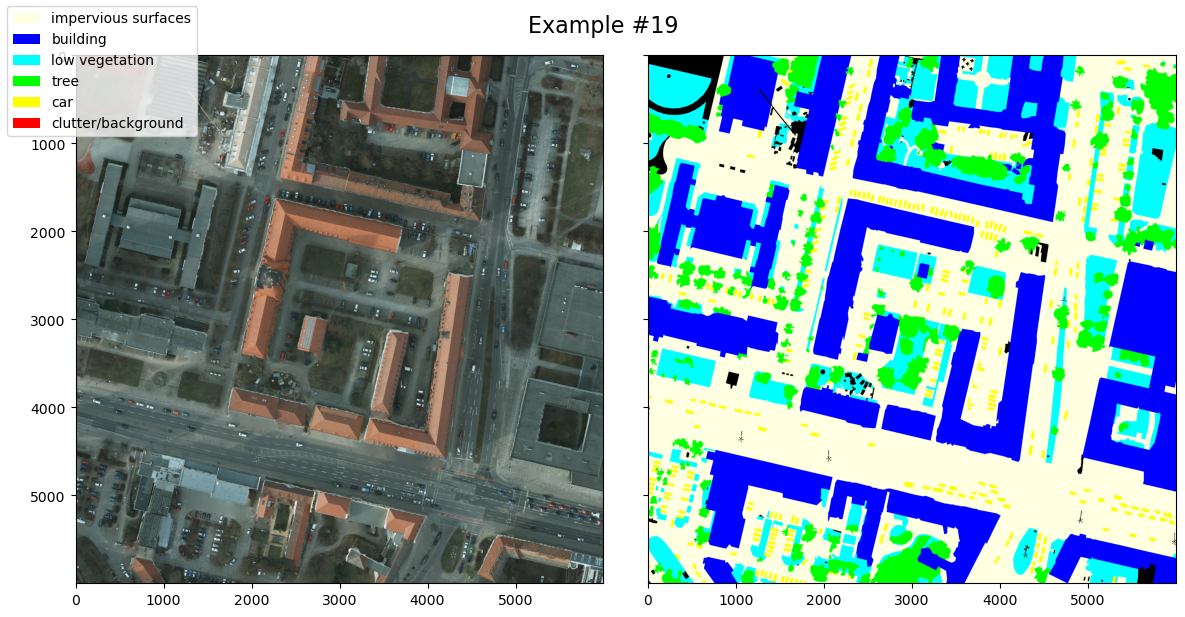

In [11]:
import matplotlib.pyplot as plt
SIZE = 800

im1 = image.resize((SIZE, SIZE))
im2 = mask_img.resize((SIZE, SIZE))

f, ax = plt.subplots(1, 2, figsize=(12,6), sharey=True)
ax[0].imshow(image, vmin=0, vmax=255)
ax[1].imshow(mask_img)

f.suptitle(f"Example #{idx}", fontsize=16)

# Extract colors and labels from the dictionary
colors = [(r / 255, g / 255, b / 255, 1) for r, g, b in idx2rgb.values()]
labels = [str(idx2label[key]) for key in idx2rgb]

# Create a legend using the extracted colors and labels
patches = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]
f.legend(patches, labels, loc='upper left')

f.tight_layout()
plt.show()

### Check Metadata and Deduce Resolution Information for Slicing

In [12]:
import rasterio 
import rioxarray

In [14]:
with rasterio.open(path+'/2_Ortho_RGB/top_potsdam_3_14_RGB.tif') as src:
    print(src.profile)
    print(src.bounds)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 6000, 'height': 6000, 'count': 3, 'crs': CRS.from_epsg(32633), 'transform': Affine(0.05, 0.0, 368176.5,
       0.0, -0.05, 5808262.6), 'blockxsize': 608, 'blockysize': 608, 'tiled': True, 'compress': 'packbits', 'interleave': 'pixel'}
BoundingBox(left=368176.5, bottom=5807962.6, right=368476.5, top=5808262.6)


### Result:
- Resolution of Potsdam data is 0.05m/pixel which result at dimension 6000x6000 in a coverage of 300x300m per image
- Resolution is much higher than the othophotos from Munich (0.05m vs 0.4m/pixel)
- Images should be divided into smaller patches of 100x100m, i.e. 2000x2000 pixel
- Further downscaling of those to 1000x1000 might be needed to get resolution of training data closer to Munich data